In [1]:
import numpy as np
import os
from cellpose import models
from cellpose import utils as cp_utils
from cellstitch.pipeline import *
from cellstitch.evaluation import *
from cellstitch.utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filenames = get_filenames("../DATA/ovules/raw/")
ap_threshold = 0.5

# Benchmark CellStitch Stitching
Generate unstitched 2D predictions:

In [3]:
flow_threshold = 1
model = models.Cellpose(gpu=True, model_type='cyto2')

In [ ]:
for filename in filenames: 
    img = np.load('../data/ovules/raw/%s' % filename)
    frames = list(img)
    unstitched, _, _, _ = model.eval(frames, flow_threshold=flow_threshold) 
    np.save('./results/unstitched/%s' % filename, np.array(unstitched))

## Get the benchmark results for EuclideanStitch:

In [3]:
def full_stitch_euclidean(masks, verbose=False):
    """
    Stitch masks in-place.
    """
    num_frame = masks.shape[0]

    prev_index = 0
    max_lbl = 0

    while Frame(masks[prev_index]).is_empty():
        prev_index += 1

    curr_index = prev_index + 1

    while curr_index < num_frame:
        if Frame(masks[curr_index]).is_empty():
            # if frame is empty, skip
            curr_index += 1
        else:
            if verbose:
                print("===Stitching frame %s with frame %s ...===" % (curr_index, prev_index))

            fp = FramePair(masks[prev_index], masks[curr_index], max_lbl=max_lbl)
            fp.stitch_euclidean()
            masks[curr_index] = fp.frame1.mask

            max_lbl = fp.max_lbl

            prev_index = curr_index
            curr_index += 1

In [4]:
data = [] 
for filename in filenames:
    print("Starting %s" % filename)
    labels = np.load('../DATA/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched_e = np.load('./results/ovules/stitching/unstitched/%s' % filename) 
    full_stitch_euclidean(ct_stitched_e)
    np.save('./results/ovules/stitching/cte_stitched/%s' % filename, ct_stitched_e)
    
    num_cells = np.unique(ct_stitched_e).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched_e)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched_e, ap_threshold)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    data.append(row)

Starting N_512_ds2x.npy


/home/yining/anaconda3/envs/segmentation/lib/python3.8/site-packages/cellpose/metrics.py:205: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


Starting N_458_ds2x.npy
Starting N_536_ds2x.npy
Starting N_294_final_crop_ds2.npy
Starting N_441_final_crop_ds2.npy
Starting N_435_final_crop_ds2.npy
Starting N_449_ds2x.npy
Starting N_425_ds2x.npy
Starting N_422_ds2x.npy
Starting N_451_ds2x.npy
Starting N_420_ds2x.npy
Starting N_454_ds2x.npy
Starting N_511_final_crop_ds2.npy
Starting N_440_ds2x.npy
Starting N_593_final_crop_ds2.npy
Starting N_404_ds2x.npy
Starting N_445_ds2x.npy
Starting N_522_final_crop_ds2.npy
Starting N_450_ds2x.npy
Starting N_428_ds2x.npy
Starting N_405_B_ds2x.npy
Starting N_517_ds2x.npy
Starting N_464_ds2x.npy
Starting N_534_ds2x.npy
Starting N_405_A_ds2x.npy
Starting N_457_ds2x.npy
Starting N_590_final_crop_ds2.npy
Starting N_487_ds2x.npy
Starting N_416_ds2x.npy
Starting N_509_ds2x.npy
Starting N_535_ds2x.npy


In [5]:
cte_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [6]:
cte_df.to_csv("./results/ovules/stitching/cte.csv", index=False)

## Get the benchmark results for cellpose: 

In [4]:
thresholds = np.arange(0.1, 1, 0.1)

In [5]:
# cellpose benchmark
data = [] 
for filename in filenames:
    labels = np.load('../data/ovules/labels/%s' % filename) 
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    for threshold in thresholds:
        unstitched = np.load('./results/ovules/stitching/unstitched/%s' % filename) 
        cp_stitched =  np.asarray(cp_utils.stitch3D(unstitched, stitch_threshold=threshold)) # compute stitched mask
        
        num_cells = np.unique(cp_stitched).size - 1
        d_num_cells = abs(num_cells - true_num_cells) / true_num_cells 
        
        avg_vol = get_avg_vol(cp_stitched)
        d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol
        
        ap, tp, fp, fn = average_precision(labels, cp_stitched, ap_threshold)
        
        row = [
            filename, 
            threshold, 
            d_num_cells, 
            d_avg_vol, 
            ap, 
            tp, 
            fp, 
            fn
        ]
        data.append(row)

In [6]:
cp_df = pd.DataFrame(data, columns=[
    "filename", 
    "threshold", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [7]:
cp_df.to_csv("cp_stitching_benchmark.csv", index=False)

## Get the benchmark results for CellStitch:

In [3]:
data = [] 
for filename in filenames:
    print("Starting %s" % filename)
    labels = np.load('../DATA/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched = np.load('./results/ovules/stitching/unstitched/%s' % filename)
    full_stitch_reverse(ct_stitched)
    np.save('./results/ovules/stitching/ct_stitched/%s' % filename, ct_stitched) 
    
    num_cells = np.unique(ct_stitched).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched, ap_threshold)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    data.append(row)

Starting N_512_ds2x.npy


/home/yining/anaconda3/envs/segmentation/lib/python3.8/site-packages/cellpose/metrics.py:205: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


Starting N_458_ds2x.npy
Starting N_536_ds2x.npy
Starting N_294_final_crop_ds2.npy
Starting N_441_final_crop_ds2.npy
Starting N_435_final_crop_ds2.npy
Starting N_449_ds2x.npy
Starting N_425_ds2x.npy
Starting N_422_ds2x.npy
Starting N_451_ds2x.npy
Starting N_420_ds2x.npy
Starting N_454_ds2x.npy
Starting N_511_final_crop_ds2.npy
Starting N_440_ds2x.npy
Starting N_593_final_crop_ds2.npy
Starting N_404_ds2x.npy
Starting N_445_ds2x.npy
Starting N_522_final_crop_ds2.npy
Starting N_450_ds2x.npy
Starting N_428_ds2x.npy
Starting N_405_B_ds2x.npy
Starting N_517_ds2x.npy
Starting N_464_ds2x.npy
Starting N_534_ds2x.npy
Starting N_405_A_ds2x.npy
Starting N_457_ds2x.npy
Starting N_590_final_crop_ds2.npy
Starting N_487_ds2x.npy
Starting N_416_ds2x.npy
Starting N_509_ds2x.npy
Starting N_535_ds2x.npy


In [4]:
ct_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [5]:
ct_df.to_csv("ct_stitching_benchmark.csv", index=False)

## Get the benchmark results for CellStitch reverse stitching:

In [ ]:
data = [] 
for filename in filenames:
    print("Starting %s" % filename)
    labels = np.load('../DATA/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched = np.load('./results/ovules/stitching/unstitched/%s' % filename) 
    full_stitch_reverse(ct_stitched)
    np.save('./results/ovules/stitching/ct_rev_stitched/%s' % filename, ct_stitched)  
    
    num_cells = np.unique(ct_stitched).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched, ap_threshold)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    data.append(row)

Starting N_512_ds2x.npy


/home/yining/anaconda3/envs/segmentation/lib/python3.8/site-packages/cellpose/metrics.py:205: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


Starting N_458_ds2x.npy
Starting N_536_ds2x.npy
Starting N_294_final_crop_ds2.npy
Starting N_441_final_crop_ds2.npy
Starting N_435_final_crop_ds2.npy
Starting N_449_ds2x.npy
Starting N_425_ds2x.npy
Starting N_422_ds2x.npy
Starting N_451_ds2x.npy
Starting N_420_ds2x.npy
Starting N_454_ds2x.npy
Starting N_511_final_crop_ds2.npy
Starting N_440_ds2x.npy
Starting N_593_final_crop_ds2.npy
Starting N_404_ds2x.npy
Starting N_445_ds2x.npy
Starting N_522_final_crop_ds2.npy
Starting N_450_ds2x.npy
Starting N_428_ds2x.npy


In [ ]:
ct_rev_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [ ]:
ct_rev_df.to_csv("./results/ovules/stitching/ct_rev.csv", index=False)

## Get the benchmark results for CellStitch 1-IoU

In [6]:
filenames

['N_512_ds2x.npy',
 'N_458_ds2x.npy',
 'N_536_ds2x.npy',
 'N_294_final_crop_ds2.npy',
 'N_441_final_crop_ds2.npy',
 'N_435_final_crop_ds2.npy',
 'N_449_ds2x.npy',
 'N_425_ds2x.npy',
 'N_422_ds2x.npy',
 'N_451_ds2x.npy',
 'N_420_ds2x.npy',
 'N_454_ds2x.npy',
 'N_511_final_crop_ds2.npy',
 'N_440_ds2x.npy',
 'N_593_final_crop_ds2.npy',
 'N_404_ds2x.npy',
 'N_445_ds2x.npy',
 'N_522_final_crop_ds2.npy',
 'N_450_ds2x.npy',
 'N_428_ds2x.npy',
 'N_405_B_ds2x.npy',
 'N_517_ds2x.npy',
 'N_464_ds2x.npy',
 'N_534_ds2x.npy',
 'N_405_A_ds2x.npy',
 'N_457_ds2x.npy',
 'N_590_final_crop_ds2.npy',
 'N_487_ds2x.npy',
 'N_416_ds2x.npy',
 'N_509_ds2x.npy',
 'N_535_ds2x.npy']

In [8]:
data = [] 
for filename in ['N_457_ds2x.npy', 'N_590_final_crop_ds2.npy','N_487_ds2x.npy','N_416_ds2x.npy','N_509_ds2x.npy','N_535_ds2x.npy']:
    print("Starting %s" % filename)
    labels = np.load('../DATA/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched = np.load('./results/ovules/stitching/unstitched/%s' % filename) 
    full_stitch(ct_stitched)
    np.save('./results/ovules/stitching/iou/%s' % filename, ct_stitched)  
    
    num_cells = np.unique(ct_stitched).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched, ap_threshold)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    data.append(row)

Starting N_457_ds2x.npy
Starting N_590_final_crop_ds2.npy
Starting N_487_ds2x.npy
Starting N_416_ds2x.npy
Starting N_509_ds2x.npy
Starting N_535_ds2x.npy


In [9]:
ct_iou_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "fn"
])

In [10]:
ct_iou_df.to_csv("./results/ovules/stitching/ct_iou.csv", index=False)

# Analyze Results

Number of cells and average volume.

In [33]:
df = pd.read_csv("./results/ovules/stitching/cte.csv")

In [34]:
df['precision'] = df['tp'] / (df['tp'] + df['fp'])
df['recall'] = df['tp'] / (df['tp'] + df['rn'])

In [40]:
col_name = 'd_avg_vol'
df[col_name].mean(), df[col_name].std()

(0.8539979834331884, 0.1296728312357535)

In [42]:
cp_df = pd.read_csv("./results/ovules/stitching/cp.csv")
cp_df['precision'] = cp_df['tp'] / (cp_df['tp'] + cp_df['fp'])
cp_df['recall'] = cp_df['tp'] / (cp_df['tp'] + cp_df['rn'])

In [55]:
col_name = 'd_avg_vol'
cp_best_df = cp_df.groupby(['filename']).min()[col_name]

In [56]:
cp_best_df.mean(), cp_best_df.std()

(0.7223935661440243, 0.26683966009498095)

In [39]:
#cp_best_df = cp_df.groupby(['filename']).min()[col_name]
#cp_best_df = cp_best_df.reset_index()
#cp_best_df = cp_best_df.drop(columns=['filename'])

#cp_all_df = cp_df[col_name]
#cp_all_df = cp_all_df.reset_index()
#cp_all_df = cp_all_df.drop(columns=['index'])

ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])

ct_iou_df = ct_iou_df[col_name]
ct_iou_df = ct_iou_df.reset_index()
ct_iou_df = ct_iou_df.drop(columns=['index'])

#cte_df = cte_df[col_name]
#cte_df = cte_df.reset_index()
#cte_df = cte_df.drop(columns=['index']) 

#ct_rev_df = ct_rev_df[col_name]
#ct_rev_df = ct_rev_df.reset_index()
#ct_rev_df = ct_rev_df.drop(columns=['index']) 

#cp_best_df['method'] = 'Cellpose_best'
#cp_all_df['method'] = 'Cellpose_all'
#cte_df['method'] = 'EuclideanStitch'
ct_df['method'] = 'CellStitch (1/IoU)'
ct_iou_df['method'] = 'CellStitch (1 - IoU)'
#ct_rev_df['method'] = 'CellStitch(bottom)'

df = pd.concat([ct_df, ct_iou_df])

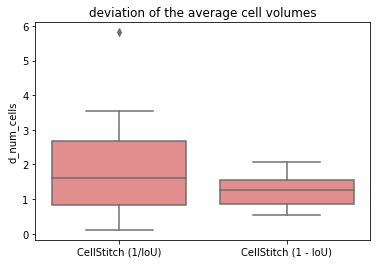

In [40]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="lightcoral")
plt.title("deviation of the average cell volumes")
ax.set(xlabel=None)
plt.savefig('./figures/%s.png' % col_name)

Average precision. 

In [33]:
# cp_df = pd.read_csv("./results/ovules/stitching/cp.csv")
ct_df = pd.read_csv("./results/ovules/stitching/ct_top.csv")
# cte_df = pd.read_csv("./results/ovules/stitching/cte.csv")
# ct_rev_df = pd.read_csv("./results/ovules/stitching/ct_rev.csv")
ct_iou_df = pd.read_csv("./results/ovules/stitching/ct_iou.csv")

In [34]:
col_name = 'ap'

In [35]:
#cp_best_df = cp_df.groupby(['filename']).max()[col_name]
#cp_best_df = cp_best_df.reset_index()
#cp_best_df = cp_best_df.drop(columns=['filename'])
#cp_all_df = cp_df[col_name]
#cp_all_df = cp_all_df.reset_index()
#cp_all_df = cp_all_df.drop(columns=['index'])

ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])

ct_iou_df = ct_iou_df[col_name]
ct_iou_df = ct_iou_df.reset_index()
ct_iou_df = ct_iou_df.drop(columns=['index'])
#cte_df = cte_df[col_name]
#cte_df = cte_df.reset_index()
#cte_df = cte_df.drop(columns=['index'])   

#ct_rev_df = ct_rev_df[col_name]
#ct_rev_df = ct_rev_df.reset_index()
#ct_rev_df = ct_rev_df.drop(columns=['index'])   

#cp_best_df['method'] = 'Cellpose_best'
#cp_all_df['method'] = 'Cellpose_all'
#cte_df['method'] = 'EuclideanStitch'
ct_df['method'] = 'CellStitch (1/IoU)'
ct_iou_df['method'] = 'CellStitch (1 - IoU)'

#ct_rev_df['method'] = 'CellStitch(bottom)'

df = pd.concat([ct_df, ct_iou_df])

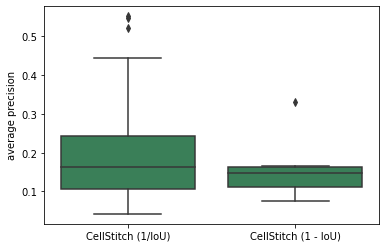

In [36]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="seagreen")
ax.set(xlabel=None)
ax.set(ylabel='average precision')
plt.savefig('./figures/%s.png' % col_name)